In [1]:
# Import libraries
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import itertools
import argparse
import sys
import time
from sklearn import preprocessing
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'


In [2]:
## Preprocessing of data
# Function to load data

def get_power_data():
    """
    Read the Individual household electric power consumption dataset
    """
    
    # Assume that the dataset is located on folder "data"
    data = pd.read_csv('./household_power_consumption.txt',
                       sep=';', low_memory=False)
#     data = pd.read_csv('../../dataset/household_power_consumption.txt',
#                        sep=';', low_memory=False)

    # Drop some non-predictive variables
    data = data.drop(columns=['Date', 'Time'], axis=1)

    #print(data.head())

    # Replace missing values
    data = data.replace('?', np.nan)

    # Drop NA
    data = data.dropna(axis=0)

    # Normalize
    standard_scaler = preprocessing.StandardScaler()
    np_scaled = standard_scaler.fit_transform(data)
    data = pd.DataFrame(np_scaled)

    # Goal variable assumed to be the first
    X = data.values[:, 1:].astype('float32')
    y = data.values[:, 0].astype('float32')

    # Create categorical y for binary classification with balanced classes
    y = np.sign(y+0.46)

    # Split train and test data here: (X_train, Y_train, X_test, Y_test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    no_class = 2                 #binary classification

    return X_train, X_test, y_train, y_test, no_class


In [3]:
X_train, X_test, y_train, y_test, no_class = get_power_data()
print("X,y types: {} {}".format(type(X_train), type(y_train)))
print("X size {}".format(X_train.shape))
print("Y size {}".format(y_train.shape))

# Create a binary variable from one of the columns.
# You can use this OR not

idx = y_train >= 0
notidx = y_train < 0
y_train[idx] = 1
y_train[notidx] = -1


# X_test = X_test/np.linalg.norm(X_test)
# X_train = X_train/np.linalg.norm(X_train)


X,y types: <class 'numpy.ndarray'> <class 'numpy.ndarray'>
X size (1536960, 6)
Y size (1536960,)


In [4]:
# print(y_train.shape)
# #print(X_train.min())
# print(X_test.max(), X_test.min())


# print(X_test.max(), X_test.min())


In [8]:

# Sigmoid function
def sigmoid(x, derivative=False):
    sigm = 1. / (1. + np.exp(-x)) 
    if derivative:
        return sigm * (1. - sigm)
    return sigm

# Define weights initialization
def initialize_w(N, d):
    return 2*np.random.random((N,d)) - 1

# Fill in feed forward propagation
def feed_forward_propagation(X, y, w_1, w_2, w_3, lmbda):
    # Fill in
    # X (N,d)
    # w_1 (d,h)
    # w_2 (h,g)
    # w_3 (g,1)
    N,d = X.shape
    layer_0 = X # (N,d)
    layer_1 = sigmoid(np.dot(layer_0, w_1)) # (N, h)
    layer_2 = sigmoid(np.dot(layer_1, w_2)) # (N, g)
    layer_3 = np.dot(layer_2, w_3) # (N, 1)
    
    return layer_0, layer_1, layer_2, layer_3
def back_propagation(y, w_1, w_2, w_3, layer_0, layer_1, layer_2, layer_3, lmbda):
    N = y.shape[0]
    y = y.reshape((-1,1))
    layer_3_delta = np.zeros_like(w_3) # (g,1)
    layer_2_delta = np.zeros_like(w_2) # (h, g)
    layer_1_delta = np.zeros_like(w_1) # (d, h)
    layer_3_delta = 2 * np.dot(layer_2.T, (layer_3 - y)) # (g,1)
    # print("np.dot(w_3,(layer_3-y)) shape ", np.dot(w_3,(layer_3-y).T).shape)
    # print(" sigmoid(np.dot(layer_1,w_2), derivative=True).T shape", sigmoid(np.dot(layer_1,w_2), derivative=True).T.shape)
    dJ_dl2 = 2 * np.dot(w_3,(layer_3-y).T) # # (g,N)
    dl2_ds2 = sigmoid(np.dot(layer_1,w_2), derivative=True).T # (g,N)

    layer_2_delta  = np.dot(dJ_dl2 * dl2_ds2, layer_1).T    
    # layer_2_delta = 2 * np.dot(np.dot(w_3,(layer_3-y).T)*sigmoid(np.dot(layer_1,w_2), derivative=True).T, layer_1).T
    ds2_dl1 = w_2 # (h,g)
    dl1_ds1 =  sigmoid(np.dot(layer_0,w_1), derivative=True).T # (h,N)
    ds1_dw1 = layer_0 # (N,d)

    layer_1_delta = np.dot(np.dot(ds2_dl1, dJ_dl2 * dl2_ds2) * dl1_ds1, ds1_dw1).T # (d,h)
    return layer_1_delta/N, layer_2_delta/N, layer_3_delta/N

def back_propagation_blocklayer(y, w_1, w_2, w_3, layer_0, layer_1, layer_2, layer_3, lmbda, activelayer = 3):
    N = y.shape[0]
    y = y.reshape((-1,1))
    layer_3_delta = np.zeros_like(w_3) # (g,1)
    layer_2_delta = np.zeros_like(w_2) # (h, g)
    layer_1_delta = np.zeros_like(w_1) # (d, h)
    layer_3_delta = 2 * np.dot(layer_2.T, (layer_3 - y)) # (g,1)
    
    if activelayer == 3:
        return layer_1_delta/N, layer_2_delta/N, layer_3_delta/N
    
    # print("np.dot(w_3,(layer_3-y)) shape ", np.dot(w_3,(layer_3-y).T).shape)
    # print(" sigmoid(np.dot(layer_1,w_2), derivative=True).T shape", sigmoid(np.dot(layer_1,w_2), derivative=True).T.shape)
    dJ_dl2 = 2 * np.dot(w_3,(layer_3-y).T) # # (g,N)
    dl2_ds2 = sigmoid(np.dot(layer_1,w_2), derivative=True).T # (g,N)

    layer_2_delta  = np.dot(dJ_dl2 * dl2_ds2, layer_1).T    
    if activelayer == 2:
        return layer_1_delta/N, layer_2_delta/N, layer_3_delta/N
    
    # layer_2_delta = 2 * np.dot(np.dot(w_3,(layer_3-y).T)*sigmoid(np.dot(layer_1,w_2), derivative=True).T, layer_1).T
    ds2_dl1 = w_2 # (h,g)
    dl1_ds1 =  sigmoid(np.dot(layer_0,w_1), derivative=True).T # (h,N)
    ds1_dw1 = layer_0 # (N,d)

    layer_1_delta = np.dot(np.dot(ds2_dl1, dJ_dl2 * dl2_ds2) * dl1_ds1, ds1_dw1).T # (d,h)
    if activelayer == 1:
        return layer_1_delta/N, layer_2_delta/N, layer_3_delta/N

# Cost function
def cost(X, y, w_1, w_2, w_3, lmbda):
    N, d = X.shape
    a1,a2,a3,a4 = feed_forward_propagation(X,y,w_1,w_2,w_3,lmbda)

#     return np.linalg.norm(a4[:,0] - y,2) ** 2 / N + lmbda * (np.linalg.norm(w_1)**2 + np.linalg.norm(w_2)**2 + np.linalg.norm(w_3)**2)
    return np.linalg.norm(a4[:,0] - y,2) ** 2 / N

# Define SGD
def SGD(X, y, w_1, w_2, w_3, lmbda, learning_rate, batch_size, iterations):
    # Complete here:
    loss_lst = []
    time_lst = []
    start = time.time()
    y = y.reshape((-1,1))
    for i in range(iterations):
        loss = cost(X_train, y_train, w_1, w_2, w_3, lmbda)
        loss_lst.append(loss)
        
        randomInd = np.arange(X.shape[0])
        np.random.shuffle(randomInd)
        randomInd = randomInd[:batch_size]
        layer_0, layer_1, layer_2, layer_3 = feed_forward_propagation(X[randomInd,:],y[randomInd,:],w_1,w_2,w_3,lmbda)
        layer_1_delta, layer_2_delta, layer_3_delta = back_propagation(y[randomInd,:], w_1, w_2, w_3, layer_0, layer_1, layer_2, layer_3, lmbda)
        
        g = (np.linalg.norm(layer_1_delta) + np.linalg.norm(layer_2_delta) + np.linalg.norm(layer_3_delta))/3
        if i%20==0:
            print("i, g, loss is ", i, g, loss)   
        if (g <= epsilon):
#             loss = cost(X_train, y_train, w_1, w_2, w_3, lmbda)
            time_lst.append(time.time()-start)
            print("converge, break! current i: ", i, loss)
            break
        
        w_1 = w_1 - learning_rate*layer_1_delta
        w_2 = w_2 - learning_rate*layer_2_delta
        w_3 = w_3 - learning_rate*layer_3_delta
    
        
#         loss = cost(X_train, y_train, w_1, w_2, w_3, lmbda)
        
#         if i%20==0:
#             print(i,loss)
        time_lst.append(time.time()-start)
    return w_1, w_2, w_3, loss_lst, time_lst

# Define SVRG here:
def SVRG(X, y, w_1, w_2, w_3, lmbda, learning_rate, T, batch_size, iterations):
    # Complete here:
    y = y.reshape((-1,1))
    N = X.shape[0]
    loss_lst = []
    time_lst = []
    start = time.time()
    for i in range(iterations):
        loss = cost(X_train, y_train, w_1, w_2, w_3, lmbda)
        loss_lst.append(loss)
        # compute all gradient and store
        layer_0, layer_1, layer_2, layer_3 = feed_forward_propagation(X,y,w_1,w_2,w_3,lmbda)
        layer_1_delta, layer_2_delta, layer_3_delta = back_propagation(y, w_1, w_2, w_3, layer_0, layer_1, layer_2, layer_3, lmbda)
            
        
        g = (np.linalg.norm(layer_1_delta) + np.linalg.norm(layer_2_delta) + np.linalg.norm(layer_3_delta))/3
        if i%20==0:
            print("i, g, loss is ", g, loss)   
        if (g <= epsilon):
#             loss = cost(X_train, y_train, w_1, w_2, w_3, lmbda)  
            time_lst.append(time.time()-start)
            
            print("converge, break! current i: ", i, loss)
            break
        
        # initialize the w_previous
        # w_previous = w.copy()
        w_1_previous, w_2_previous, w_3_previous = w_1.copy(), w_2.copy(), w_3.copy()
        for t in range(T//batch_size):
            # random sample
            # randomInd = int(np.random.rand() * N)
            randomInd = np.arange(N)
            np.random.shuffle(randomInd)
            randomInd = randomInd[:batch_size]
            # randomInd = np.random.randint(0,N)
            layer_0_p1, layer_1_p1, layer_2_p1, layer_3_p1 = feed_forward_propagation(X[randomInd,:],y[randomInd,:],w_1_previous,w_2_previous,w_3_previous,lmbda)
            layer_1_delta_p1, layer_2_delta_p1, layer_3_delta_p1 = back_propagation(y[randomInd,:], w_1_previous, w_2_previous, w_3_previous, layer_0_p1, layer_1_p1, layer_2_p1, layer_3_p1, lmbda)

            layer_0_p2, layer_1_p2, layer_2_p2, layer_3_p2 = feed_forward_propagation(X[randomInd,:],y[randomInd,:],w_1,w_2,w_3,lmbda)
            layer_1_delta_p2, layer_2_delta_p2, layer_3_delta_p2 = back_propagation(y[randomInd,:], w_1, w_2, w_3, layer_0_p2, layer_1_p2, layer_2_p2, layer_3_p2, lmbda)
            
            # calculate the update term
            # part1 = function_gradient_vectorization(x[:,randomInd], y[:,randomInd], w_previous, lambda_, gradclip = gradclip)
            # part2 = function_gradient_vectorization(x[:,randomInd], y[:,randomInd], w, lambda_, gradclip = gradclip)
            # part3 = g

            w_1_previous = w_1_previous - learning_rate * (layer_1_delta_p1 - layer_1_delta_p2 + layer_1_delta)
            w_2_previous = w_2_previous - learning_rate * (layer_2_delta_p1 - layer_2_delta_p2 + layer_2_delta)
            w_3_previous = w_3_previous - learning_rate * (layer_3_delta_p1 - layer_3_delta_p2 + layer_3_delta)

            # w_previous = w_previous - alpha * (part1 - part2 + part3)
            
        # w = w_previous
        
        w_1, w_2, w_3 = w_1_previous, w_2_previous, w_3_previous
        time_lst.append(time.time()-start)
        
#         loss = cost(X_train, y_train, w_1, w_2, w_3, lmbda)
#         if i%20==0:
#             print(i,loss)
    
    return w_1, w_2, w_3, loss_lst, time_lst

# Define GD here:
def GD(X, y, w_1,w_2,w_3, lmbda, learning_rate, iterations):
    N = X.shape[0]
    loss_lst = []
    time_lst = []
    start = time.time()
    for i in range(iterations):
        loss = cost(X_train, y_train, w_1, w_2, w_3, lmbda)
        loss_lst.append(loss)
        
        layer_0, layer_1, layer_2, layer_3 = feed_forward_propagation(X, y, w_1,w_2,w_3,lmbda)
        layer_1_delta, layer_2_delta, layer_3_delta = back_propagation(y, w_1, w_2, w_3, layer_0, layer_1, layer_2, layer_3,lmbda)
        
        g = (np.linalg.norm(layer_1_delta) + np.linalg.norm(layer_2_delta) + np.linalg.norm(layer_3_delta))/3
        if i%20==0:
            print("i, g, loss is ", i, g, loss)   
        if (g <= epsilon):
#             loss = cost(X_train, y_train, w_1, w_2, w_3, lmbda)
            time_lst.append(time.time()-start)
            
            print("converge, break! current i: ", i, loss)
            break
#         w_1 = w_1 -  learning_rate * layer_1_delta + (lmbda / N * w_1)
#         w_2 = w_2 - learning_rate * layer_2_delta + (lmbda / N * w_2)
#         w_3 = w_3 - learning_rate * layer_3_delta + (lmbda / N * w_3)
        w_1 = w_1 -  learning_rate * layer_1_delta
        w_2 = w_2 - learning_rate * layer_2_delta
        w_3 = w_3 - learning_rate * layer_3_delta
#         loss = cost(X_train, y_train, w_1, w_2, w_3, lmbda)
#         if i%20==0:
#             print(i,loss)
        time_lst.append(time.time()-start)

    return w_1, w_2, w_3, loss_lst, time_lst

# Define projected GD here:
def PGD(X, y, w_1,w_2,w_3, lmbda, learning_rate, iterations, noise = None):
    # Complete here:
    N = X.shape[0]
    loss_lst = []
    time_lst = []
    start = time.time()
    for i in range(iterations):
        loss = cost(X_train, y_train, w_1, w_2, w_3, lmbda)
        loss_lst.append(loss)
        
        layer_0, layer_1, layer_2, layer_3 = feed_forward_propagation(X, y, w_1,w_2,w_3,lmbda)
        layer_1_delta, layer_2_delta, layer_3_delta = back_propagation(y, w_1, w_2, w_3, layer_0, layer_1, layer_2, layer_3,lmbda)
        
        g = (np.linalg.norm(layer_1_delta) + np.linalg.norm(layer_2_delta) + np.linalg.norm(layer_3_delta))/3
        if i%20==0:
            print("i, g, loss is ", i, g, loss)   
        if (g <= epsilon) or (loss<0.2):
#             loss = cost(X_train, y_train, w_1, w_2, w_3, lmbda)
            time_lst.append(time.time()-start)
            
            print("converge, break! current i: ", i,loss)
            break
            
        if noise == None:
            # the noise level is determined by the delta
            noise = []
            noise.append((np.random.random((w_1.shape)) * 2 - 1) *np.mean(layer_1_delta))
            noise.append((np.random.random((w_2.shape)) * 2 - 1) *np.mean(layer_2_delta))
            noise.append((np.random.random((w_3.shape)) * 2 - 1) *np.mean(layer_3_delta))
        
        w_1 = w_1 -  learning_rate * layer_1_delta + noise[0]*0.01
        w_2 = w_2 - learning_rate * layer_2_delta + noise[1]*0.01
        w_3 = w_3 - learning_rate * layer_3_delta + noise[2]*0.01
#         loss = cost(X_train, y_train, w_1, w_2, w_3, lmbda)
        
#         if i%20==0:
#             print(i,loss)
        time_lst.append(time.time()-start)

    return w_1, w_2, w_3, loss_lst, time_lst

# Define BCD here:
def BCD(X, y, w_1,w_2,w_3, lmbda, learning_rate, iterations, strategy = 0, blockrate = 0.5):
    loss_lst = []
    time_lst = []
    start = time.time()
    # Complete here:
    # 2 strategies:
    # a. randomly select weight by a random mask (random coordinate selection)
    # b. we train the layers asynchronously to archieve the goal of blocking coordinate (cyclic update rule) 
    for i in range(iterations):
        loss = cost(X_train, y_train, w_1, w_2, w_3, lmbda)
        loss_lst.append(loss)
        
        layer_0, layer_1, layer_2, layer_3 = feed_forward_propagation(X, y, w_1,w_2,w_3,lmbda)
        layer_1_delta, layer_2_delta, layer_3_delta = back_propagation(y, w_1, w_2, w_3, layer_0, layer_1, layer_2, layer_3,lmbda)
        
        g = (np.linalg.norm(layer_1_delta) + np.linalg.norm(layer_2_delta) + np.linalg.norm(layer_3_delta))/3
        if i%20==0:
            print("i, g, loss is ", i, g, loss)   
        if (g <= epsilon):
            time_lst.append(time.time()-start)
            
#             loss = cost(X_train, y_train, w_1, w_2, w_3, lmbda)
            print("converge, break! current i: ", i,loss)
            break
            
        if strategy == 0:
            layer_0, layer_1, layer_2, layer_3 = feed_forward_propagation(X, y, w_1,w_2,w_3,lmbda)
            # generate random mask for each layer
            l1_mask = np.random.choice([1, 0], size=layer_1_delta.shape, p=[blockrate, 1 - blockrate])
            l2_mask = np.random.choice([1, 0], size=layer_2_delta.shape, p=[blockrate, 1 - blockrate])
            l3_mask = np.random.choice([1, 0], size=layer_3_delta.shape, p=[blockrate, 1 - blockrate])
            w_1 = w_1 - learning_rate * layer_1_delta * l1_mask
            w_2 = w_2 - learning_rate * layer_2_delta * l2_mask
            w_3 = w_3 - learning_rate * layer_3_delta * l3_mask
        else:
            # cyclic
            # layer 1
            layer_0, layer_1, layer_2, layer_3 = feed_forward_propagation(X, y, w_1,w_2,w_3,lmbda)
            layer_1_delta, _, _ = back_propagation_blocklayer(y, w_1, w_2, w_3, layer_0, layer_1, layer_2, layer_3,lmbda, 1)
            w_1 = w_1 - learning_rate * layer_1_delta
            # layer 2
            layer_0, layer_1, layer_2, layer_3 = feed_forward_propagation(X, y, w_1,w_2,w_3,lmbda)
            _, layer_2_delta, _ = back_propagation_blocklayer(y, w_1, w_2, w_3, layer_0, layer_1, layer_2, layer_3,lmbda, 2)
            w_2 = w_2 - learning_rate * layer_2_delta
            # layer 3
            layer_0, layer_1, layer_2, layer_3 = feed_forward_propagation(X, y, w_1,w_2,w_3,lmbda)
            _, _, layer_3_delta = back_propagation_blocklayer(y, w_1, w_2, w_3, layer_0, layer_1, layer_2, layer_3,lmbda, 3)
            w_3 = w_3 - learning_rate * layer_3_delta
#         loss = cost(X_train, y_train, w_1, w_2, w_3, lmbda)
#         if i%20==0:
#             print(i,loss)
        time_lst.append(time.time()-start)

    return w_1, w_2, w_3, loss_lst, time_lst

In [9]:
"""
w_size = 10

# Initialize weights for debug
w_1 = initialize_w(X_train.shape[1], w_size)

w_2 = initialize_w(w_size,w_size+1)

w_3 = initialize_w(w_size+1, 1)

lmbda = 0

layer_0, layer_1, layer_2, layer_3 = feed_forward_propagation(X_test, y_test, w_1, w_2, w_3, lmbda)

print("layer_0 shape ", layer_0.shape)
print("layer_1 shape ",layer_1.shape)
print("layer_2 shape ",layer_2.shape)
print("layer_3 shape ",layer_3.shape)

layer_1_delta, layer_2_delta, layer_3_delta = back_propagation(y_test, w_1, w_2, w_3, layer_0, layer_1, layer_2, layer_3, lmbda)


print("w_3 shape ",w_3.shape)
print("w_2 shape ",w_2.shape)
print("w_1 shape ",w_1.shape)

print("layer_3_delta shape", layer_3_delta.shape)
print("layer_2_delta shape", layer_2_delta.shape)
print("layer_1_delta shape", layer_1_delta.shape)
"""




'\nw_size = 10\n\n# Initialize weights for debug\nw_1 = initialize_w(X_train.shape[1], w_size)\n\nw_2 = initialize_w(w_size,w_size+1)\n\nw_3 = initialize_w(w_size+1, 1)\n\nlmbda = 0\n\nlayer_0, layer_1, layer_2, layer_3 = feed_forward_propagation(X_test, y_test, w_1, w_2, w_3, lmbda)\n\nprint("layer_0 shape ", layer_0.shape)\nprint("layer_1 shape ",layer_1.shape)\nprint("layer_2 shape ",layer_2.shape)\nprint("layer_3 shape ",layer_3.shape)\n\nlayer_1_delta, layer_2_delta, layer_3_delta = back_propagation(y_test, w_1, w_2, w_3, layer_0, layer_1, layer_2, layer_3, lmbda)\n\n\nprint("w_3 shape ",w_3.shape)\nprint("w_2 shape ",w_2.shape)\nprint("w_1 shape ",w_1.shape)\n\nprint("layer_3_delta shape", layer_3_delta.shape)\nprint("layer_2_delta shape", layer_2_delta.shape)\nprint("layer_1_delta shape", layer_1_delta.shape)\n'

In [10]:
# Should be a hyperparameter that you tune, not an argument - Fill in the values
lmbda =0.001
w_size = 50
lr = 0.02
iterations = 500 # 100
T = 2000
batch_size = 100
epsilon = 0.1

# Initialize weights
w_1 = initialize_w(X_train.shape[1], w_size)

w_2 = initialize_w(w_size,w_size)

w_3 = initialize_w(w_size, 1)

# print("GD\tinitial loss is :", cost(X_train, y_train, w_1, w_2, w_3, lmbda))
# start_gd = time.time()
# w_1_star,w_2_star,w_3_star,loss_gd,time_gd = GD(X_train, y_train, w_1, w_2, w_3, lmbda, lr, iterations)
# end_gd = time.time()
# print("Training time for GD: ", end_gd-start_gd)

print("PGD\tinitial loss is :", cost(X_train, y_train, w_1, w_2, w_3, lmbda))
start_pgd = time.time()
w_1_star,w_2_star,w_3_star,loss_pgd,time_pgd = PGD(X_train, y_train, w_1, w_2, w_3, lmbda, lr, iterations)
end_pgd = time.time()
print("Training time for PGD: ", end_pgd-start_pgd)


# print("SGD\tinitial loss is :", cost(X_train, y_train, w_1, w_2, w_3, lmbda))
# start_sgd = time.time()
# w_1_star,w_2_star,w_3_star,loss_sgd,time_sgd = SGD(X_train, y_train, w_1, w_2, w_3, lmbda, lr, batch_size, iterations)
# end_sgd = time.time()
# print("Training time for SGD: ", end_sgd-start_sgd)



# print("SVRG\tinitial loss is :", cost(X_train, y_train, w_1, w_2, w_3, lmbda))
# start_svrg = time.time()
# w_1_star1,w_2_star1,w_3_star1,loss_svrg,time_svrg = SVRG(X_train, y_train, w_1, w_2, w_3, lmbda, lr, T, batch_size, iterations)
# end_svrg = time.time()
# print("Training time for SVRG: ", end_svrg-start_svrg)

# print("BCD\tinitial loss is :", cost(X_train, y_train, w_1, w_2, w_3, lmbda))
# strategy = 0 # 0 for random block mask, 1 for layer block
# blockrate = 0.5
# start_bcd = time.time()
# w_1_star,w_2_star,w_3_star ,loss_bcd,time_bcd = BCD(X_train, y_train, w_1, w_2, w_3, lmbda, lr, iterations, strategy, blockrate)
# end_bcd = time.time()
# print("Training time for BCD: ", end_bcd-start_bcd)


PGD	initial loss is : 2.2892894984202625
i, g, loss is  0 5.284163179436155 2.2892894984202625
i, g, loss is  20 0.4833716362254423 0.4580153892252612
i, g, loss is  40 0.35103067554787587 0.3805720560188617
i, g, loss is  60 0.31458724850344444 0.35762694828334346
i, g, loss is  80 0.29691419970679 0.3489391142626257
i, g, loss is  100 0.2833167939304973 0.3458258561892211


KeyboardInterrupt: 

In [ ]:
lmbda =0.01
w_size = 50
lr = 0.01
iterations = 500 # 100
T = 2000
batch_size = 100
epsilon = 0.1

# Initialize weights
w_1 = initialize_w(X_train.shape[1], w_size)

w_2 = initialize_w(w_size,w_size)

w_3 = initialize_w(w_size, 1)

# print("GD\tinitial loss is :", cost(X_train, y_train, w_1, w_2, w_3, lmbda))
# start_gd = time.time()
# w_1_star,w_2_star,w_3_star, loss_gd1,time_gd1 = GD(X_train, y_train, w_1, w_2, w_3, lmbda, lr, iterations)
# end_gd = time.time()
# print("Training time for GD: ", end_gd-start_gd)

print("PGD\tinitial loss is :", cost(X_train, y_train, w_1, w_2, w_3, lmbda))
start_pgd = time.time()
w_1_star,w_2_star,w_3_star, loss_pgd1,time_pgd1 = PGD(X_train, y_train, w_1, w_2, w_3, lmbda, lr, iterations)
end_pgd = time.time()
print("Training time for PGD: ", end_pgd-start_pgd)


# print("SGD\tinitial loss is :", cost(X_train, y_train, w_1, w_2, w_3, lmbda))
# start_sgd = time.time()
# w_1_star,w_2_star,w_3_star, loss_sgd1,time_sgd1 = SGD(X_train, y_train, w_1, w_2, w_3, lmbda, lr, batch_size, iterations)
# end_sgd = time.time()
# print("Training time for SGD: ", end_sgd-start_sgd)



# print("SVRG\tinitial loss is :", cost(X_train, y_train, w_1, w_2, w_3, lmbda))
# start_svrg = time.time()
# w_1_star1,w_2_star1,w_3_star1, loss_svrg1,time_svrg1 = SVRG(X_train, y_train, w_1, w_2, w_3, lmbda, lr, T, batch_size, iterations)
# end_svrg = time.time()
# print("Training time for SVRG: ", end_svrg-start_svrg)

# print("BCD\tinitial loss is :", cost(X_train, y_train, w_1, w_2, w_3, lmbda))
# strategy = 0 # 0 for random block mask, 1 for layer block
# blockrate = 0.5
# start_bcd = time.time()
# w_1_star,w_2_star,w_3_star, loss_bcd1,time_bcd1 = BCD(X_train, y_train, w_1, w_2, w_3, lmbda, lr, iterations, strategy, blockrate)
# end_bcd = time.time()
# print("Training time for BCD: ", end_bcd-start_bcd)


In [ ]:
lmbda =0.001
w_size = 50
lr = 0.01
iterations = 500 # 100
T = 2000
batch_size = 100
epsilon = 0.1

# Initialize weights
w_1 = initialize_w(X_train.shape[1], w_size)

w_2 = initialize_w(w_size,w_size)

w_3 = initialize_w(w_size, 1)

# print("GD\tinitial loss is :", cost(X_train, y_train, w_1, w_2, w_3, lmbda))
# start_gd = time.time()
# w_1_star,w_2_star,w_3_star, loss_gd2, time_gd2 = GD(X_train, y_train, w_1, w_2, w_3, lmbda, lr, iterations)
# end_gd = time.time()
# print("Training time for GD: ", end_gd-start_gd)

print("PGD\tinitial loss is :", cost(X_train, y_train, w_1, w_2, w_3, lmbda))
start_pgd = time.time()
w_1_star,w_2_star,w_3_star, loss_pgd2,time_pgd2 = PGD(X_train, y_train, w_1, w_2, w_3, lmbda, lr, iterations)
end_pgd = time.time()
print("Training time for PGD: ", end_pgd-start_pgd)


# print("SGD\tinitial loss is :", cost(X_train, y_train, w_1, w_2, w_3, lmbda))
# start_sgd = time.time()
# w_1_star,w_2_star,w_3_star, loss_sgd2,time_sgd2 = SGD(X_train, y_train, w_1, w_2, w_3, lmbda, lr, batch_size, iterations)
# end_sgd = time.time()
# print("Training time for SGD: ", end_sgd-start_sgd)



# print("SVRG\tinitial loss is :", cost(X_train, y_train, w_1, w_2, w_3, lmbda))
# start_svrg = time.time()
# w_1_star1,w_2_star1,w_3_star2, loss_svrg1,time_svrg2 = SVRG(X_train, y_train, w_1, w_2, w_3, lmbda, lr, T, batch_size, iterations)
# end_svrg = time.time()
# print("Training time for SVRG: ", end_svrg-start_svrg)

# print("BCD\tinitial loss is :", cost(X_train, y_train, w_1, w_2, w_3, lmbda))
# strategy = 0 # 0 for random block mask, 1 for layer block
# blockrate = 0.5
# start_bcd = time.time()
# w_1_star,w_2_star,w_3_star, loss_bcd2,time_bcd2 = BCD(X_train, y_train, w_1, w_2, w_3, lmbda, lr, iterations, strategy, blockrate)
# end_bcd = time.time()
# print("Training time for BCD: ", end_bcd-start_bcd)


PGD	initial loss is : 20.176253373106913
i, g, loss is  0 18.402618930288615 20.176253373106913
i, g, loss is  20 1.4032849326877506 1.3583449577411986
i, g, loss is  40 1.2965252490048045 1.066252280797918
i, g, loss is  60 0.9676234840573926 0.6407774338500488
i, g, loss is  80 0.5948413480640112 0.36996117792611144


In [ ]:
# Should be a hyperparameter that you tune, not an argument - Fill in the values
parser = argparse.ArgumentParser()
parser.add_argument('--lambda', type=float, default=0., dest='lmbda') 
parser.add_argument('--w_size', type=int, default=10, dest='w_size')
parser.add_argument('--lr', type=float, default=0.01)
parser.add_argument('--iterations', type=int, default=10)

args = parser.parse_args()

batch_size = 100

# Initialize weights
w_1 = initialize_w(X_train.shape[1], args.w_size)

w_2 = initialize_w(args.w_size,args.w_size)

w_3 = initialize_w(args.w_size, 1)

# Get iterations
iterations = args.iterations
# Define plotting variables
fig, ax = plt.subplots(2, 1, figsize=(16, 8))

# Define the optimizers for the loop
optimizers = [
        {# Fill in the hyperparameters
            "opt": SGD(X_train, y_train, w_1, w_2, w_3, args.lmbda, args.lr, batch_size),
            "name": "SGD",
            "inner": # Fill in
        },
        {# Fill in the hyperparameters
            "opt": SVRG(X_train, y_train, w_1, w_2, w_3, args.lmbda, args.lr),
            "name": "SVRG",
            "inner": # Fill in
        },
        {# Fill in the hyperparameters
            "opt": GD(
                X_train, y_train, w_1, w_2, w_3, learning_rate=args.lr,
                lmbda=args.lmbda, iterations=iterations),
            "name": "GD",
            "inner": # Fill in
        },
        {# Fill in the hyperparameters
            "opt": PGD(
                X_train, y_train, w_1, w_2, w_3, learning_rate=args.lr,
                lmbda=args.lmbda, iterations=iterations, noise=),
            "name": "PGD",
            "inner": # Fill in
        },
        {# Fill in the hyperparameters
            "opt": BCD(
                X_train, y_train, w_1, w_2, w_3, learning_rate=args.lr,
                lmbda=args.lmbda, iterations=iterations),
            "name": "BCD",
            "inner": # Fill in
        }
    ]

In [ ]:
# Run the iterates over the algorithms above

for opt in optimizers:
    #
    # Fill in



No handles with labels found to put in legend.
No handles with labels found to put in legend.


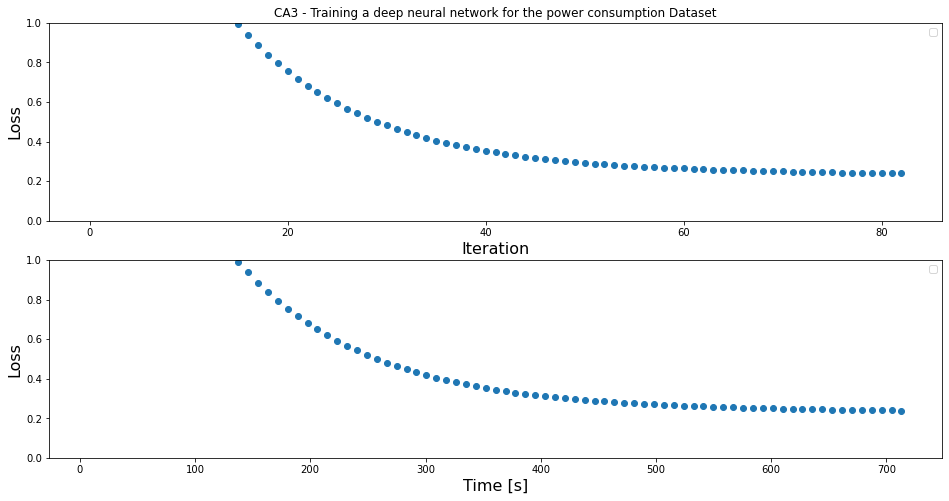

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(16, 8))

# Plot results
ax[0].legend(loc="upper right")
ax[0].set_xlabel(r"Iteration", fontsize=16)
ax[0].set_ylabel("Loss", fontsize=16)
ax[0].set_title("CA3 - Training a deep neural network for the power consumption Dataset")
ax[0].set_ylim(ymin=0)
ax[0].scatter(np.arange(len(loss_gd)), loss_gd)


ax[1].legend(loc="upper right")
ax[1].set_xlabel(r"Time [s]", fontsize=16)
ax[1].set_ylabel("Loss", fontsize=16)
ax[1].set_ylim(ymin=0)
ax[1].scatter(time_gd, loss_gd)

plt.savefig("power.png")